## Multivariate Gaussian

Basic **formula** is:

$$\mathcal{N}(x|\mu,\Sigma) = \frac{1}{(2\pi)^{D/2}}\frac{1}{|\Sigma|^{1/2}}\exp [−\frac{1}{2}(x−\mu)^T\Sigma^{-1}(x−\mu)]$$

Properties:
- $\Sigma_{ij} = cov[x_i, x_j]$
- $\Sigma$ is symmetric

## Fisher's Linear Discriminant Classification

Fisher's linear discriminant is a classification method that projects high-dimensional data onto a line and performs classification in this one-dimensional space. The projection maximizes the distance between the means of the two classes while minimizing the variance within each class. This defines the Fisher criterion, which is **maximized** over all linear projections, $w$:

$$\mathcal{J}(w) = \frac{|m_1-m_2|^2}{s_0^2 + s_1^2}$$

where $m$ represents a mean, $s^2$ represents a variance, and the subscripts denote the two classes. In signal theory, this criterion is also known as the signal-to-interference ratio. Maximizing this criterion yields a closed form solution that involves the inverse of a covariance-like matrix.

## Classification using Fisher Linear Discriminant Model

Here we are using 2-classes input as an example. We can view a linear classification model in terms of **dimensionality reduction**

* First project down onto a single dimension:
$$y = \mathbf{w}^T\mathbf{x}$$
* Then place a **threshold** on y and classify as class $\mathcal{C}_1$ if $y\geq -w_0$ and as class $\mathcal{C}_0$ otherwise. (threshold is *minus* the bias)
* Result of projecting D-dimensions onto 1-D leads to a **loss of information**, which will further result in projection overlaps.
* By adjusting **w**, we can maximise the separation between the two classes.

### Maximise Projected Means Between Classes to Find w
* Mean of class k is:
$$\mathbf{m}_k = \frac{\sum_{n\in\mathcal{C}_k} x_n}{N_k}$$
* Choose **w** to maximise:
$$\mathbf{w}^T(\mathbf{m_1}-\mathbf{m_0})$$
* The Distance between projected means, $m_k = \mathbf{w}^T\mathbf{m}_k$
* Choose a Threshold and normalise **w**
$$\sum_i w^2_i = 1$$
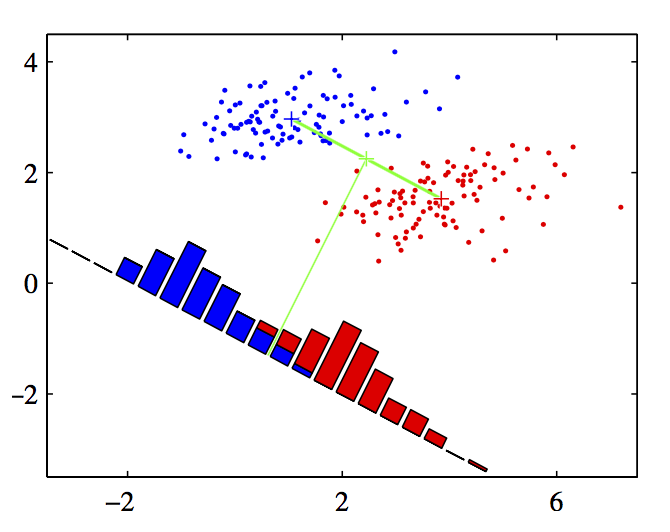

In [ ]:
def max_lik_mv_gaussian_approx(data):
    """
    Finds the maximum likelihood mean and covariance matrix for gaussian data
    samples (data)

    parameters
    ----------
    data - data array, 2d array of samples, each row is assumed to be an
      independent sample from a multi-variate gaussian

    returns
    -------
    mu - mean vector
    Sigma - 2d array corresponding to the covariance matrix  
    """
    # the mean sample is the mean of the rows of data
    N, dim = data.shape
    mu = np.mean(data,0)
    Sigma = np.zeros((dim,dim))
    # the covariance matrix requires us to sum the dyadic product of
    # each sample minus the mean.
    for x in data:
        # subtract mean from data point, and reshape to column vector
        # note that numpy.matrix is being used so that the * operator
        # in the next line performs the outer-product v * v.T 
        x_minus_mu = np.matrix(x - mu).reshape((dim,1))
        # the outer-product v * v.T of a k-dimentional vector v gives
        # a (k x k)-matrix as output. This is added to the running total.
        Sigma += x_minus_mu * x_minus_mu.T
    # Sigma is unnormalised, so we divide by the number of datapoints
    Sigma /= N
    # we convert Sigma matrix back to an array to avoid confusion later
    return mu, np.asarray(Sigma)

def maximum_separation_projection(inputs, targets):
    """
    Finds the projection vector that maximises the distance between the 
    projected means

    parameters
    ----------
    inputs - a 2d input matrix (array-like), each row is a data-point
    targets - 1d target vector (array-like) -- can be at most 2 classes ids
        0 and 1

    returns
    -------
    weights - a normalised projection vector
    """
    # get the shape of the data
    N, D = inputs.shape
    # separate the classes
    inputs0 = inputs[targets==0]
    inputs1 = inputs[targets==1]
    # find maximum likelihood approximations to the two data-sets
    m0,_ = max_lik_mv_gaussian_approx(inputs0)
    m1,_ = max_lik_mv_gaussian_approx(inputs1)
    # calculate weights vector
    weights = m1-m0
    return weights

### Maximise Fisher Criterion to Find w

* Within-class variance of projected data is:
$$s^2_k = \sum_{n\in\mathcal{C}_k}(y_n - m_k)^2$$
where $y_n = \mathbf{w}^T\mathbf{x}_n$
* Total within class variance $s^2_0 + s^2_1$
* Between class variance $(m_1^2-m^2_0)^2$
* Maximise the Fisher Criterion

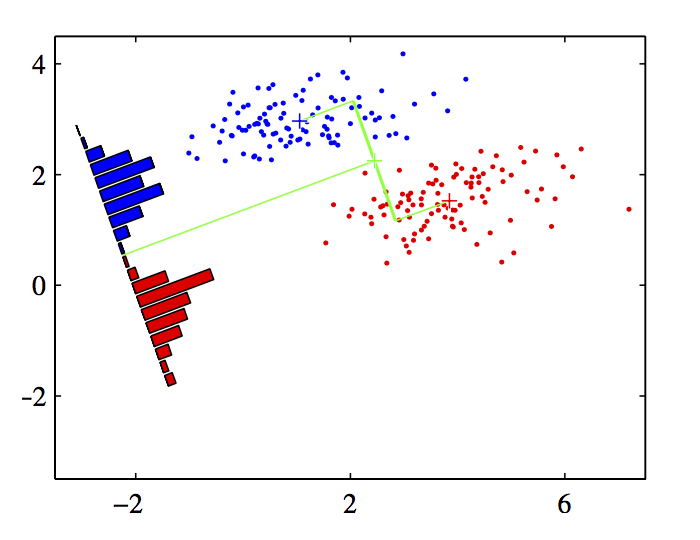

In [1]:
def fisher_linear_discriminant_projection(inputs, targets):
    """
    Finds the direction of best projection based on Fisher's linear discriminant

    parameters
    ----------
    inputs - a 2d input matrix (array-like), each row is a data-point
    targets - 1d target vector (array-like) -- can be at most 2 classes ids
        0 and 1

    returns
    -------
    weights - a normalised projection vector corresponding to Fisher's linear 
        discriminant
    """
    # get the shape of the data
    N, D = inputs.shape
    # separate the classes
    inputs0 = inputs[targets==0]
    inputs1 = inputs[targets==1]
    # find maximum likelihood approximations to the two data-sets
    m0, S_0 = max_lik_mv_gaussian_approx(inputs0)
    m1, S_1 = max_lik_mv_gaussian_approx(inputs1)
    # convert the mean vectors to column vectors (type matrix)
    m0 = np.matrix(m0).reshape((D,1))
    m1 = np.matrix(m1).reshape((D,1))
    # calculate the total within-class covariance matrix (type matrix)
    S_W = np.matrix(S_0 + S_1)
    # calculate weights vector
    weights = np.array(np.linalg.inv(S_W)*(m1-m0))
    # normalise
    weights = weights/np.sum(weights)
    # we want to make sure that the projection is in the right direction
    # i.e. giving larger projected values to class1 so:
    projected_m0 = np.mean(project_data(inputs0, weights))
    projected_m1 = np.mean(project_data(inputs1, weights))
    if projected_m0 > projected_m1:
        weights = -weights
    return weights